In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from numpy import inf
from matplotlib import rc
rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [ ]:
def getData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def getLeptonData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [7]:
##Selection on event variables
def applyEventCuts(df):
    print '################### ' 
    print 'Applying event selection'
    temp = df 
    #temp = applyCut(temp, 'y < 0.95 and y>0.01', '0.01 < y < 0.95')
    temp = applyCut(temp, 'y < 0.85 and y>0.1', '0.1 < y < 0.85')

    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    print '################### \n' 
    return temp


## Selection on event and jet variables
def applyJetCuts(df):
    print '################### ' 
    print 'Applying jet selection'
    temp = df
    temp = applyCut(temp, 'jet_pt>5', ' jet pT > 5 GeV') 
    temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)
    print '################### \n' 

    return temp

In [5]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

## Get data

In [8]:
df_inclusive = getLeptonData(['NC_10_275.root'])
xsec = np.mean(df_inclusive['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df_inclusive.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)
lumi = 100 # in units of fb-1. 
to_counts = to_cross_section*1000*lumi #1000 accounts to pass from pb to fb
##Apply selection
df_inclusive = applyEventCuts(df_inclusive)



Processed NC_10_275.root in 0.1 seconds
xsection 17642.51 [pb]
accepted events 90000
################### 
Applying event selection
0.1 < y < 0.85 48234  fraction kept: 53.6
Q2>25 47934  fraction kept: 99.4
################### 



In [9]:
##Total cross-section: 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)

Integrated rate 1764.251 [M]


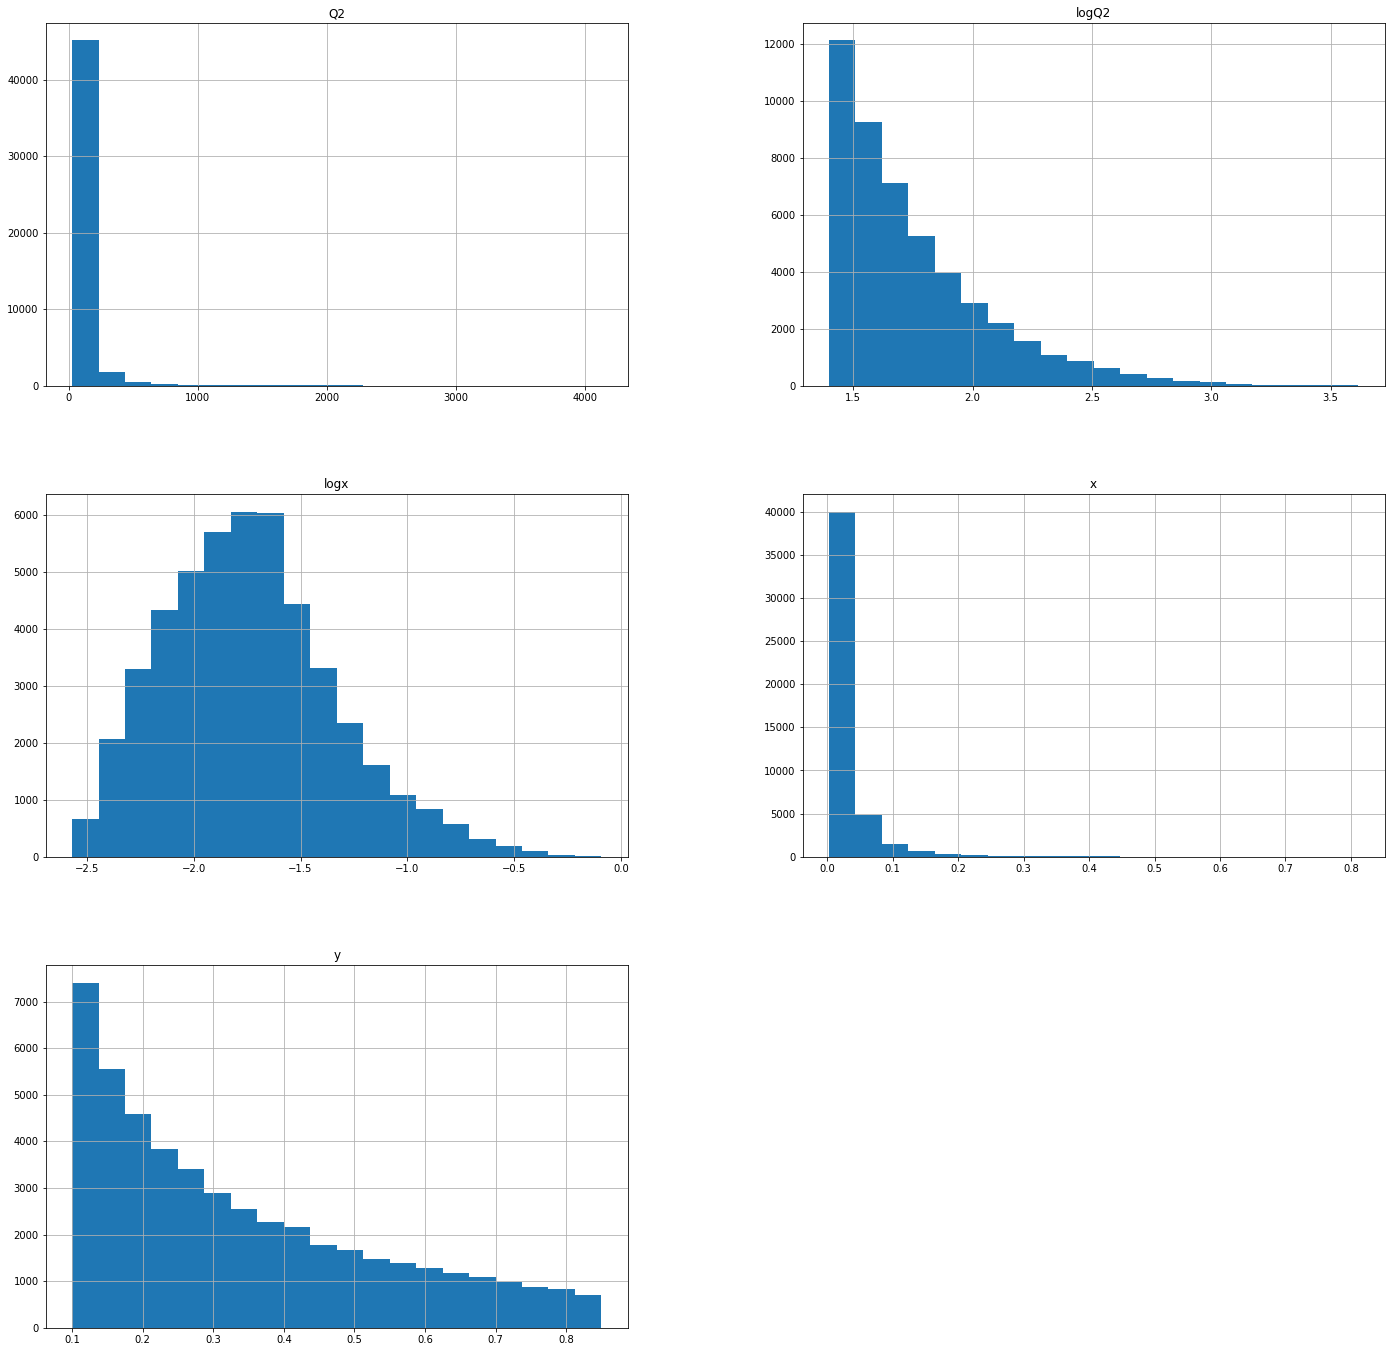

In [10]:
rc('text', usetex=False)
df_inclusive.hist(figsize=(24,24),bins=20,column=['x','Q2','logx','logQ2','y'])
plt.show()

In [11]:
df_jet      = getJetData(['NC_10_275.root'])
df_jet = applyEventCuts(df_jet)
df_jet = applyJetCuts(df_jet)


Processed NC_10_275.root in 2.3 seconds
################### 
Applying event selection
0.1 < y < 0.85 123021  fraction kept: 56.7
Q2>25 122132  fraction kept: 99.3
################### 

################### 
Applying jet selection
 jet pT > 5 GeV 46175  fraction kept: 37.8
dphi_e_jet>3.14159-0.4 24663  fraction kept: 53.4
################### 



Cross section [1.37595844e+08 9.10239921e+07 4.82565578e+07 2.50054795e+07
 1.21256406e+07 6.05486060e+06 2.71391596e+06 9.27781261e+05
 3.32523835e+05 6.64146545e+04 9.02752373e+03]


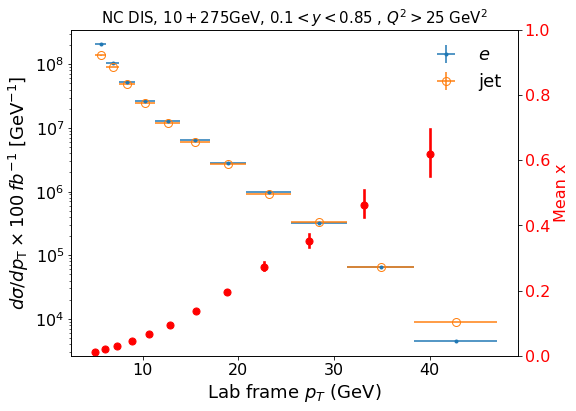

In [25]:
import seaborn as sns
nbins = 12
minpt = 5
maxpt = df_jet['jet_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
y, x  = np.histogram(df_inclusive.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts
yerr = np.sqrt(y)

y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)

plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$e$')


y, x  = np.histogram(df_jet.query('dphi<0.4 and jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jet')


plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
plt.title(r'NC DIS, $10+275 \mathrm{GeV}$, $0.1 < y < 0.85$ , $Q^2 > 25\ \mathrm{GeV^2}$',   fontsize=15)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(40),nbins),fit_reg=None,color='red')
ax2.set_ylabel('Mean x' ,color='red',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax2.set_ylim([0.0,1.0])

#ax2.scale('log')
plt.savefig('CrossSection_NC.png', bbox_inches='tight')
plt.savefig('CrossSection_NC.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

## Factors for statistical projection

In [38]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #efficiency
penalty = np.sqrt(2)# coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

label = " 10+275 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$"

## Sivers asymmetry (phi) for various electron pT

6.903715  mean lepton pt
0.26904738  mean inelasticity
9.953906  mean jet p
6.821711  mean jet pT
count    8005.000000
mean        6.821711
std         1.171033
min         5.000384
25%         5.937205
50%         6.683362
75%         7.496855
max        12.980215
Name: jet_pt, dtype: float64
0.02802587  mean x
70.98337  mean Q2
count    8005.000000
mean       70.983368
std        30.593220
min        40.115871
25%        53.399551
50%        63.723064
75%        76.663589
max       398.292664
Name: Q2, dtype: float64
 
9.890196  mean lepton pt
0.2729288  mean inelasticity
16.533989  mean jet p
9.458419  mean jet pT
count    2857.000000
mean        9.458419
std         1.590455
min         5.000280
25%         8.455307
50%         9.441971
75%        10.378680
max        20.443800
Name: jet_pt, dtype: float64
0.056576386  mean x
145.73705  mean Q2
count    2857.000000
mean      145.737045
std        58.459518
min        90.184662
25%       113.193604
50%       129.754196
75%       154

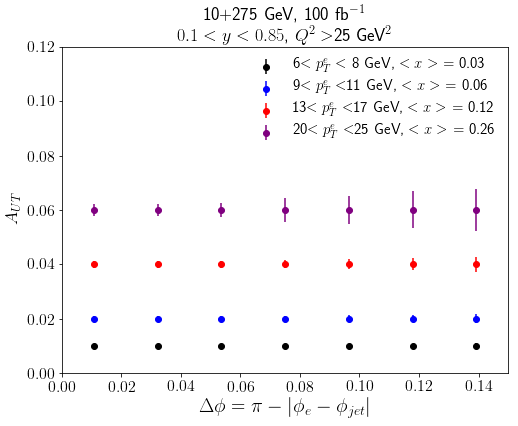

In [27]:
rc('text', usetex=True)

def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.06]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0),(20,25)]):
    maxdphi = 0.15
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    mean_x = df_cut['x'].mean()
    printSummary(df_cut)

    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none', color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f GeV, $<x>$ = %2.2f'%(edges[0],edges[1],mean_x))
    print ' '
####
plt.legend(frameon=False,loc='best',ncol=2,fontsize=16)
plt.ylim([0.0,0.12])
#plt.ylim([-0.15,0.15])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlim([0.0,0.15])

plt.title(label, fontsize=18)
plt.legend(loc='best', fontsize=15,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers.png', bbox_inches='tight')
plt.savefig('AUT_Sivers.pdf', bbox_inches='tight')

## Sivers vs x 

10.5827055  mean lepton pt
0.22853598  mean inelasticity
19.43658  mean jet p
10.145828  mean jet pT
count    3914.000000
mean       10.145828
std         2.463803
min         5.000280
25%         8.345102
50%         9.886174
75%        11.729374
max        20.449053
Name: jet_pt, dtype: float64
0.06836911  mean x
171.85863  mean Q2
count    3914.000000
mean      171.858627
std       118.974831
min        55.627480
25%        92.494707
50%       127.916122
75%       206.638866
max       878.911987
Name: Q2, dtype: float64
 
16.66824  mean lepton pt
0.22129084  mean inelasticity
43.345375  mean jet p
16.04961  mean jet pT
count    534.000000
mean      16.049610
std        3.363754
min        5.481516
25%       13.728287
50%       15.832336
75%       18.318988
max       30.303143
Name: jet_pt, dtype: float64
0.17124237  mean x
416.70926  mean Q2
count     534.000000
mean      416.709259
std       274.535248
min       167.568695
25%       237.313541
50%       311.529221
75%       483.144

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


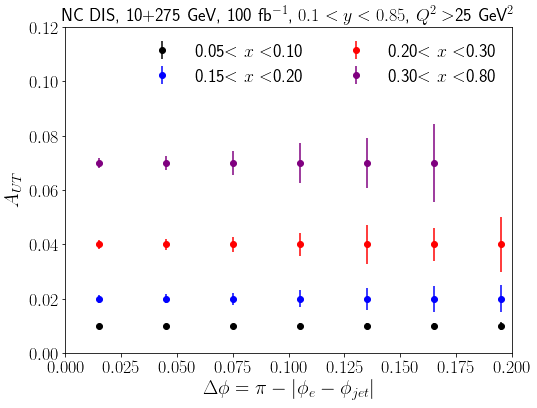

In [40]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxdphi = 0.6
    nbins  = 20
    df_cut = df_jet.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)

    y, x  = np.histogram(df_cut['dphi'],bins=nbins,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency # take efficiency hit
    y[y<100] = 0

    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    x[erry == inf] = 1000

    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.12])
plt.xlim([0.0,0.2])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('NC DIS, 10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=18,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=20)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_xbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xbins.pdf', bbox_inches='tight')

## Sivers(x) for various Q2 bins

In [ ]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.025]
colores = ['black','blue','red','purple']


for counter,edges in enumerate([(25,200000)]):
    df_cut = df.query('Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-2,0.0,9))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials ##total number of counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter])
    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.05])
plt.xlim([0.01,1.0])
#plt.yscale('log')

plt.xscale('log')
plt.text(0.012, 0.04, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xdependence.pdf', bbox_inches='tight')

## Distributions

In [ ]:

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04]
colores = ['black','blue','red']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = np.pi
    df_cut = df.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,0.4))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials
    erry = np.sqrt(y)
    plt.errorbar(x,y ,fmt='o',ls='none',color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f'%(edges[0],edges[1]))

####
plt.legend(frameon=False,loc='best')
#plt.ylim([0.0,0.07])

#plt.text(0.01, 0.05, '$e+p^{\uparrow}$, 18+100 GeV \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$\n 100 fb$^{-1}$', fontsize=18)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.ylabel('$d\sigma $x 100 fb$^{-1}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_distributions.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_distributions.pdf', bbox_inches='tight')

Q2 > 100.00 and Q2<200.00
9.56947  mean lepton pt
0.31731924  mean inelasticity
16.418518  mean jet p
9.188006  mean jet pT
count    4941.000000
mean        9.188006
std         2.072015
min         5.000280
25%         7.736587
50%         9.167204
75%        10.557529
max        20.443800
Name: jet_pt, dtype: float64
0.054379594  mean x
138.5872  mean Q2
count    4941.000000
mean      138.587204
std        27.504272
min       100.006081
25%       114.860855
50%       133.656021
75%       159.577805
max       199.985809
Name: Q2, dtype: float64
###########
Q2 > 200.00 and Q2<500.00
13.672743  mean lepton pt
0.34904093  mean inelasticity
28.639929  mean jet p
13.13941  mean jet pT
count    2646.000000
mean       13.139410
std         3.350812
min         5.055072
25%        10.944047
50%        13.280405
75%        15.429938
max        25.783398
Name: jet_pt, dtype: float64
0.10839223  mean x
301.3803  mean Q2
count    2646.000000
mean      301.380310
std        79.768745
min       200

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in divide


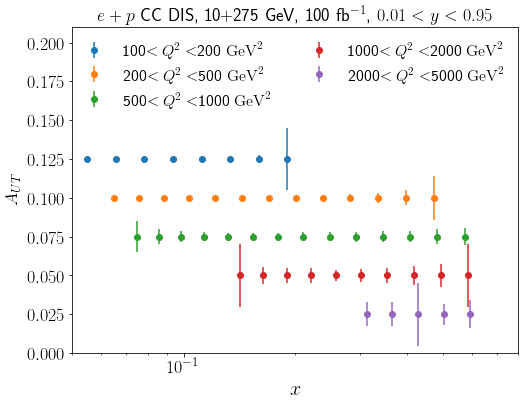

In [36]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
asymmetry = [0.125,0.1,0.075,0.05,0.025]
#colores = ['black','blue','red','purple']



for counter,edges in enumerate([(100,200),(200,500), (500,1000),(1000,2000), (2000,5000)]):
    selection = 'Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1])
    df_cut = df_jet.query(selection)
    print selection
    printSummary(df_cut)
    print '###########'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-1.3,-0.22,15))
    x = (x[1:]+x[:-1])/2
    x = x + 0.01*counter
    y = y*to_counts
    y = y*efficiency 
    y[y<200] = 0
    # take efficiency hit
    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    x[erry == inf] = 1000
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',label='%2.0f$<Q^{2}<$%2.0f $\mathrm{GeV}^{2}$'%(edges[0],edges[1]))
    
    #plt.errorbar(x,y,label='%2.0f$<Q^{2}<$%2.0f'%(edges[0],edges[1]))

    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.21])
plt.xlim([0.05,0.8])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#plt.yscale('log')

plt.xscale('log')
plt.title('$e+p$ CC DIS, 10+275 GeV, 100 fb$^{-1}$, $0.01<y<0.95$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_NC_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_NC_Sivers_xdependence.pdf', bbox_inches='tight')

11.758011  mean lepton pt
0.27280354  mean inelasticity
23.594425  mean jet p
11.93786  mean jet pT
count    3423.000000
mean       11.937860
std         1.384869
min        10.000227
25%        10.746688
50%        11.679699
75%        13.027123
max        14.995576
Name: jet_pt, dtype: float64
0.08245662  mean x
214.32803  mean Q2
count    3423.000000
mean      214.328033
std       123.673744
min        34.273941
25%       141.073868
50%       186.630035
75%       252.687187
max      1507.127319
Name: Q2, dtype: float64
###########
18.004444  mean lepton pt
0.28555658  mean inelasticity
46.374535  mean jet p
18.159136  mean jet pT
count    1263.000000
mean       18.159136
std         2.514803
min        15.000814
25%        16.070842
50%        17.509426
75%        19.706427
max        24.959663
Name: jet_pt, dtype: float64
0.18417469  mean x
509.14578  mean Q2
count    1263.000000
mean      509.145782
std       279.452240
min        84.914940
25%       337.767014
50%       439.04388

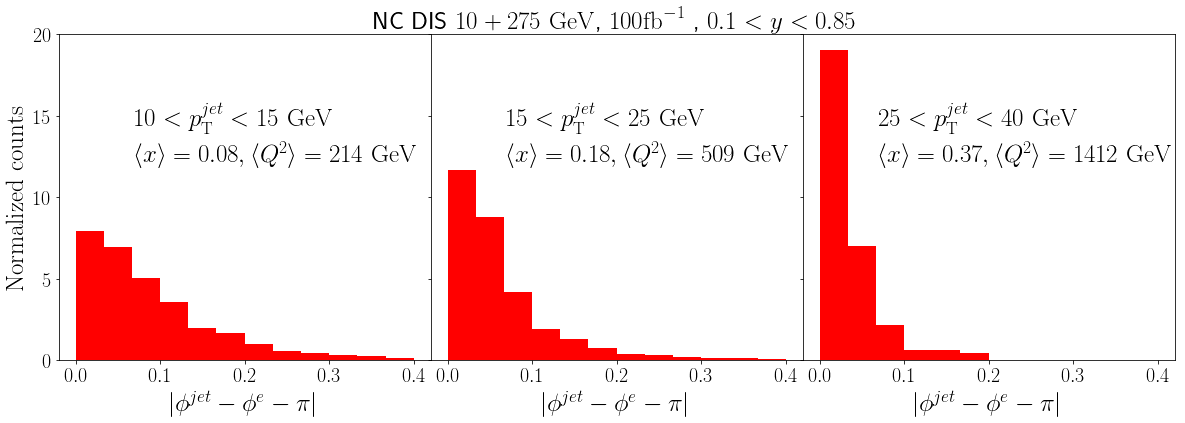

In [47]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,25),(25,40)]):

    df_cut = df_jet.query('jet_pt > %2.2f and jet_pt<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['dphi'],bins=12,range=(0,0.4),normed=True,color='red')
    
    axs[counter].xaxis.set_label_text(r'$|\phi^{jet}-\phi^e-\pi|$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,12, r' $ %2.0f< p_{\mathrm{T}}^{jet} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS $10+275$ $\mathrm{GeV}$,  $100\mathrm{fb}^{-1}$ , $0.1<y<0.85$',fontsize=25)  

plt.savefig('NC_LeptonJetAzimuthal.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetAzimuthal.pdf', bbox_inches='tight')